# DA6 - Model Evaluation

In this course, we are working towards two types of "usage" for statistics and analytics:
1. How to perform some statistical analyses for hypothesis testing using Python. This is similar to what you have been doing so far in other courses, and what you will most likely use for your thesis.
2. How to use statistics for **predictive analytics**, i.e., make predictions using digital trace data.

This week, we focus on model evaluation - building more complex models (i.e., with more variables) and alternative algorithms (besides regression). 

By the end of the tutorials of this week, you should acquire:

**Knowledge on:**
* Model evaluation - for both statistical testing and SML
* Using different SML algorithms

**Skills:**
* Train/test split
* Create and interpret a confusion matrix and a precision & recall report


First, let's import the packages we need (and that we used in the last session):

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LinearRegression
import statsmodels.api as sm
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline

## The case

We'll focus on the same case as last week, but we will *only* focus on the binary dependent variable (bounce) in order to explore some of the algorithms that are available with machine learning. For continuous variables we often tend to use mostly linear regression, so what we covered last week was a good start. For binary variables, however, there are several options - which we'll explore more in this session.

Going back to our case: Our website has launched new campaigns to increase engagement with the website, and engagement being defined as ensuring that the user ~~sees more pages (totals_pageviews) and~~ does not leave the website upon entering through the campaign (landing_isExit, binary). We also have several variables that can be used either as control variables, or as other predictors. We will not have hypotheses for them now, but will explore their influence on bouncing.

To summarize, we have one general RQ:

**RQ:** To what extent have the new campaigns increased engagement (~~pageviews and~~lower bounce) compared to other referrals to the website?

One set of hypotheses for bounce:
* *H2a.* Users entering the website via the affiliate campaign will be less likely to leave the website on the first page (bounce) compared to users entering from non-campaign referrals.
* *H2b.* Users entering the website via the CPC campaign will be less likely to leave the website on the first page (bounce) compared to users entering from non-campaign referrals.

Finally, I want to compare both campaigns:
* RQ2: To what extent do the CPC and Affiliate campaigns differ in terms of bounce likelihood?


    

### Important note:
I will reuse the data cleaning steps that we used last week, so will put too much focus here. For your A1, you need to make sure you're explaining things step by step.

# Loading data

Here we are loading and briefly inspecting the dataset. More information on how to do it - and how to do it following all the steps - can be seen in DA2 and DA3.

In [2]:
data = pd.read_pickle('googlestore_DA5weeklychallenges.pkl')

In [3]:
len(data)

52308

Note: I will select here 10% of the sample so you can follow the tutorial also at home. Normally we'd use the full dataset (as 52K observations is still somewhat of a small dataset for SML).

In [4]:
data = data.sample(frac=0.1, random_state = 42)

In [5]:
data.head()

,affiliate,channelGrouping,cpc,date,device_browser,device_deviceCategory,device_isMobile,device_operatingSystem,fullVisitorId,geoNetwork_city,...,trafficSource_adwordsClickInfo_slot,trafficSource_campaign,trafficSource_isTrueDirect,trafficSource_keyword,trafficSource_medium,trafficSource_referralPath,trafficSource_source,visitId,visitNumber,visitStartTime
36548,0,Referral,0,20171010,Chrome,desktop,False,Macintosh,6413139757155395885,Austin,...,NaN,(not set),NaN,NaN,(none),/,(direct),1507650614,1,1507650614
26376,0,Display,1,20171007,Chrome,mobile,True,Android,1122408680230456408,NaN,...,RHS,1000557 | GA | US | en | Hybrid | GDN Text+Ban...,NaN,(User vertical targeting),cpc,NaN,google,1507418877,1,1507418877
21940,0,Organic Search,0,20171006,Chrome,desktop,False,Macintosh,5963631948501878610,Mexico City,...,NaN,(not set),NaN,(not provided),organic,NaN,google,1507316316,1,1507316316
8907,0,Organic Search,0,20171003,Chrome,mobile,True,Android,233830236249633791,NaN,...,NaN,(not set),NaN,(not provided),organic,NaN,google,1507067994,1,1507067994
36441,0,Direct,0,20171010,Chrome,desktop,False,Linux,6912427824452801459,Cambridge,...,NaN,(not set),True,NaN,(none),NaN,(direct),1507648677,2,1507648677


In [6]:
data.columns

Index(['affiliate', 'channelGrouping', 'cpc', 'date', 'device_browser',
       'device_deviceCategory', 'device_isMobile', 'device_operatingSystem',
       'fullVisitorId', 'geoNetwork_city', 'geoNetwork_continent',
       'geoNetwork_country', 'geoNetwork_metro', 'geoNetwork_networkDomain',
       'geoNetwork_region', 'geoNetwork_subContinent', 'isExit',
       'landing_appInfo_landingScreenName', 'landing_appInfo_screenDepth',
       'landing_appInfo_screenName', 'landing_contentGroup_contentGroup1',
       'landing_contentGroup_contentGroup2',
       'landing_contentGroup_contentGroup3',
       'landing_contentGroup_contentGroup4',
       'landing_contentGroup_contentGroup5', 'landing_hour',
       'landing_isEntrance', 'landing_isExit', 'landing_minute',
       'landing_page_hostname', 'landing_page_pagePath',
       'landing_page_pagePathLevel1', 'landing_page_pagePathLevel2',
       'landing_page_pagePathLevel3', 'landing_page_pagePathLevel4',
       'landing_page_pageTitle', 'la

In [7]:
data.dtypes

affiliate                                          int64
channelGrouping                                   object
cpc                                                int64
date                                               int64
device_browser                                    object
device_deviceCategory                             object
device_isMobile                                     bool
device_operatingSystem                            object
fullVisitorId                                     object
geoNetwork_city                                   object
geoNetwork_continent                              object
geoNetwork_country                                object
geoNetwork_metro                                  object
geoNetwork_networkDomain                          object
geoNetwork_region                                 object
geoNetwork_subContinent                           object
isExit                                             int64
landing_appInfo_landingScreenNa

In [8]:
data.isna().sum()

affiliate                                           0
channelGrouping                                     0
cpc                                                 0
date                                                0
device_browser                                      0
device_deviceCategory                               0
device_isMobile                                     0
device_operatingSystem                              0
fullVisitorId                                       0
geoNetwork_city                                  2697
geoNetwork_continent                                0
geoNetwork_country                                  0
geoNetwork_metro                                 2697
geoNetwork_networkDomain                            0
geoNetwork_region                                2697
geoNetwork_subContinent                             0
isExit                                              0
landing_appInfo_landingScreenName                   1
landing_appInfo_screenDepth 

In [9]:
data['trafficSource_medium'].value_counts()

organic      2273
cpc          1326
(none)        989
referral      545
affiliate      75
cpm            23
Name: trafficSource_medium, dtype: int64

## Data cleaning

Here we are taking steps to prepare the variables that are important for the analysis. This is just a brief overview. You have seen a lot more info in DA3.

In [10]:
data['landing_isExit'].value_counts()

True    3066
Name: landing_isExit, dtype: int64

In [11]:
def fix_landing(landing):
    if str(landing).lower() == 'nan':
        return 0
    return 1

In [12]:
data['isExit'] = data['landing_isExit'].apply(fix_landing)

In [13]:
data['isExit'].describe()

count   5231.000
mean       0.586
std        0.493
min        0.000
25%        0.000
50%        1.000
75%        1.000
max        1.000
Name: isExit, dtype: float64

We want to understand if campaigns from affiliates or using cpc are performing better than other ways that visitors have to get to the site.

In [14]:
def check_category(source, variablename):
    if source == variablename:
        return 1
    return 0

In [15]:
data['cpc'] = data['trafficSource_medium'].apply(check_category, args=('cpc',))
data['affiliate'] = data['trafficSource_medium'].apply(check_category, args=('affiliate',))

Here I am generating categories that will be relevant for my testing. More information can be found at the FAQ video on creating categories (see FAQ section in the general repository).

In [16]:
def generate_other(row):
    if row['cpc'] == 1:
        row['other_campaign'] = 0
    elif row['affiliate'] == 1:
        row['other_campaign'] = 0
    else:
        row['other_campaign'] = 1
    return row

In [17]:
data = data.apply(generate_other, axis=1)

In [18]:
def generate_category(row):
    if row['cpc'] == 1:
        row['cat_campaign'] = 'cpc'
    if row['affiliate'] == 1:
        row['cat_campaign'] = 'affiliate'
    if row['other_campaign'] == 1:
        row['cat_campaign'] = 'other'
    return row

In [19]:
data = data.apply(generate_category, axis=1)

In [20]:
data[['cpc', 'affiliate','other_campaign']].describe()

,cpc,affiliate,other_campaign
count,5231.000,5231.000,5231.000
mean,0.253,0.014,0.732
std,0.435,0.119,0.443
min,0.000,0.000,0.000
25%,0.000,0.000,0.000
50%,0.000,0.000,1.000
75%,1.000,0.000,1.000
max,1.000,1.000,1.000


In [21]:
data['cat_campaign'].value_counts(normalize=True)

other       0.732
cpc         0.253
affiliate   0.014
Name: cat_campaign, dtype: float64

In [22]:
data[['totals_pageviews', 'cpc', 'affiliate', 'other_campaign', 'isExit']].isna().sum()

totals_pageviews    0
cpc                 0
affiliate           0
other_campaign      0
isExit              0
dtype: int64

## Adding some control variables

We are interested in knowning whether a campaign leads to lower levels of bouncing (leaving the website upon entering it), or not. There could be some additional factors influencing this - which we may be able to detect. Of course behavior of the user *after* they entered the website does not make sense - people who bounce won't have these metrics.

However, information about the user her or himself may help. For example, type of browser, or whether they accessed via a mobile device or not.

In [23]:
data['device_isMobile'].value_counts()

False    2718
True     2513
Name: device_isMobile, dtype: int64

Let me convert the device_isMobile variable from boolean (True/False) to binary (0/1).

In [24]:
data['device_isMobile'] = data['device_isMobile'].astype(int)

In [25]:
data['device_isMobile'].value_counts()

0    2718
1    2513
Name: device_isMobile, dtype: int64

In [26]:
data['device_browser'].value_counts()

Chrome               3465
Safari                870
Samsung Internet      304
Android Webview       191
Firefox               161
Internet Explorer      73
Opera Mini             49
Edge                   47
UC Browser             24
Opera                  21
Safari (in-app)        13
Amazon Silk             5
Android Browser         4
YaBrowser               1
Puffin                  1
Seznam                  1
Coc Coc                 1
Name: device_browser, dtype: int64

In [27]:
data['browser_Chrome'] = data['device_browser'].apply(check_category, args=('Chrome',))

In [28]:
data['browser_Chrome'].value_counts()

1    3465
0    1766
Name: browser_Chrome, dtype: int64

In [29]:
data[['browser_Chrome', 'device_isMobile']].isna().sum()

browser_Chrome     0
device_isMobile    0
dtype: int64

## Data exploration and visualisation
Here we are looking at the descriptive statistics of the final dataset and using visualisations to understand the relationship between variables. You have seen more about this in DA4.

In [30]:
data[['cpc', 'affiliate', 'other_campaign', 'isExit', 'device_isMobile', 'browser_Chrome']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
cpc,5231.000,0.253,0.435,0.000,0.000,0.000,1.000,1.000
affiliate,5231.000,0.014,0.119,0.000,0.000,0.000,0.000,1.000
other_campaign,5231.000,0.732,0.443,0.000,0.000,1.000,1.000,1.000
isExit,5231.000,0.586,0.493,0.000,0.000,1.000,1.000,1.000
device_isMobile,5231.000,0.480,0.500,0.000,0.000,0.000,1.000,1.000
browser_Chrome,5231.000,0.662,0.473,0.000,0.000,1.000,1.000,1.000


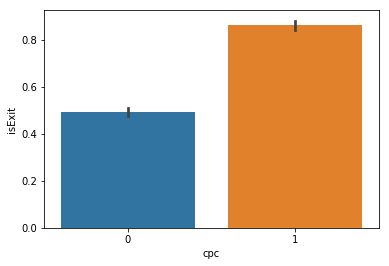

In [31]:
sns.barplot(x='cpc', y='isExit', data=data)

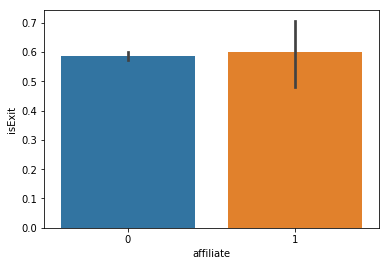

In [32]:
sns.barplot(x='affiliate', y='isExit', data=data)

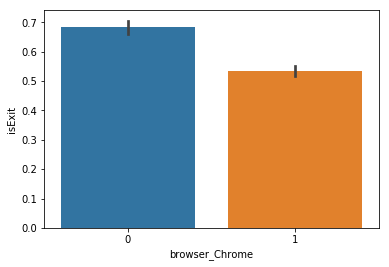

In [33]:
sns.barplot(x='browser_Chrome', y='isExit', data=data)

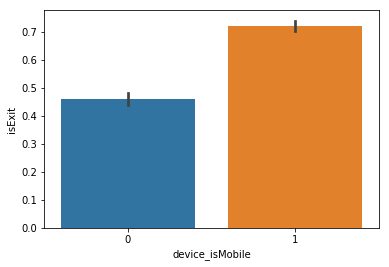

In [34]:
sns.barplot(x='device_isMobile', y='isExit', data=data)

## Modelling and hypothesis testing

We'll start with logistic regression this week again, as our dependent variable is binary (bounce). If we were only using statistical testing, we'd have the idea of a (pseudo) R2 to allow us to understand how good the model is - i.e., how well it explains the variance of the dependent variable.

However, we will use other algorithms that are not regression-based. This means that they don't generally have an R2 to report. R2 is even not provided by scikit-learn. 

### How do we compare the models then?

Based on their actual performance. For each case, we know if the visitor bounced or not, and we know the predictions made by the model (as we saw last week). So we can compare different models in terms of how good they are in predicting the DV.

The problem now shifts to how can we ensure that we have a level playing field across models. Some algorithms - or the inclusion of many independent variables - can lead to a model almost "memorizing" the dataset. Meaning it has a great performance in the data that it used for learning, but is unable to generalize. This means its predictions in new data (where we only have the IV's, but not the DV) will be poor. This is called *overfitting*  in very simplistic terms.

To prevent overfitting, it's a best practice in SML to split our dataset in two:
* A **training dataset** that we provide to the algorithm as input to learn the influence of the features (IV's) on the target (DV)
* A **test dataset** that we **do not** provide to the algorithm as an input. We instead reserve it to **test** the model after the training is done. As such, it is data that the model has not seen while being trained, and allows us to understand if it will generalize well.

As a note, there are more advanced alternatives to this. You may want to have a look at what cross-validation and the train/validation/test split are. For now, we'll start with the basics: the train/test split.




## Train/test split

Importing the function from sklearn that will help us:

In [35]:
from sklearn.model_selection import train_test_split

In [36]:
train, test = train_test_split(data, test_size=0.2, random_state=42)

What did the command above do?

1. I asked for a train and a test set to be created
2. I indicated that the data to be used was a dataframe called "data"
3. I indicated that the size of the test set should be 20% of the total dataset
4. The random_state is optional, but is an interesting thing to use. As the split between train/test includes randomizing the order of the rows, you'll always get different train/test splits every time you run the command. Using random_state makes sure that they always look the same.

In [37]:
train.head()

,affiliate,channelGrouping,cpc,date,device_browser,device_deviceCategory,device_isMobile,device_operatingSystem,fullVisitorId,geoNetwork_city,...,trafficSource_keyword,trafficSource_medium,trafficSource_referralPath,trafficSource_source,visitId,visitNumber,visitStartTime,other_campaign,cat_campaign,browser_Chrome
17926,0,Referral,0,20171005,Chrome,desktop,0,Windows,6244135294744706546,NaN,...,NaN,(none),/,(direct),1507234447,3,1507234447,1,other,1
19272,0,Direct,0,20171005,Chrome,desktop,0,Macintosh,9320966557116773522,Irvine,...,NaN,(none),NaN,(direct),1507258333,1,1507258333,1,other,1
2549,0,Display,1,20171001,Chrome,mobile,1,Android,8351405687284151166,NaN,...,(User vertical targeting),cpc,NaN,google,1506912201,2,1506912201,0,cpc,1
30621,0,Organic Search,0,20171008,Chrome,desktop,0,Windows,1574863029652135950,Jakarta,...,(not provided),organic,NaN,google,1507528244,1,1507528244,1,other,1
16912,0,Display,1,20171005,Android Webview,mobile,1,Android,7265310316190326716,Washington,...,(User vertical targeting),cpc,NaN,google,1507218081,1,1507218081,0,cpc,0


In [38]:
len(train)

4184

In [39]:
test.head()

,affiliate,channelGrouping,cpc,date,device_browser,device_deviceCategory,device_isMobile,device_operatingSystem,fullVisitorId,geoNetwork_city,...,trafficSource_keyword,trafficSource_medium,trafficSource_referralPath,trafficSource_source,visitId,visitNumber,visitStartTime,other_campaign,cat_campaign,browser_Chrome
45522,0,Display,1,20171013,Safari,desktop,0,Macintosh,1338548340175567353,NaN,...,(automatic matching),cpc,NaN,google,1507893724,1,1507893724,0,cpc,0
19901,0,Display,1,20171006,Samsung Internet,mobile,1,Android,4554879046502406644,(not set),...,(automatic matching),cpc,NaN,google,1507273479,1,1507273479,0,cpc,0
19718,0,Organic Search,0,20171005,Chrome,desktop,0,Windows,8219017373829637442,NaN,...,(not provided),organic,NaN,google,1507268979,1,1507268979,1,other,1
41775,0,Organic Search,0,20171011,Firefox,desktop,0,Windows,7453418045224821117,NaN,...,(not provided),organic,NaN,google,1507778718,1,1507778718,1,other,0
51420,0,Organic Search,0,20171015,Safari,desktop,0,Macintosh,597605757037454068,NaN,...,(not provided),organic,NaN,google,1508099984,2,1508099984,1,other,0


In [40]:
len(test)

1047

In [41]:
len(data), len(train), len(test), len(train) / len(data), len(test) / len(data)

(5231, 4184, 1047, 0.7998470655706366, 0.2001529344293634)

As I can see above, the split turned out OK, and the datasets in the size I expect

## Probabilities for leaving the website using Logistic Regression

First, using "traditional" (frequentist) statistics. But for a **binary** dependent variable. We therefore need to use logistic regression.

To make sure my results are comparable with the supervised machine learning model, I'll use only the train data.

In [42]:
target = "isExit"
features = ['cpc',  'affiliate']

In [43]:
logit_stats = sm.Logit(train[target], sm.add_constant(train[features]))

/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [44]:
result_logit = logit_stats.fit()

Optimization terminated successfully.
         Current function value: 0.617615
         Iterations 6


In [45]:
print(result_logit.summary())

                           Logit Regression Results                           
Dep. Variable:                 isExit   No. Observations:                 4184
Model:                          Logit   Df Residuals:                     4181
Method:                           MLE   Df Model:                            2
Date:                Tue, 03 Mar 2020   Pseudo R-squ.:                 0.08987
Time:                        16:54:51   Log-Likelihood:                -2584.1
converged:                       True   LL-Null:                       -2839.3
                                        LLR p-value:                1.546e-111
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0416      0.036     -1.154      0.249      -0.112       0.029
cpc            1.9123      0.098     19.575      0.000       1.721       2.104
affiliate      0.2800      0.265      1.058      0.2

## Now let's see what happens if I add the additional user variables

In [46]:
features_controls = ['cpc', 'affiliate', 'browser_Chrome', 'device_isMobile']

In [47]:
logit_stats_user = sm.Logit(train[target], sm.add_constant(train[features_controls]))

In [48]:
result_logit_user = logit_stats_user.fit()

Optimization terminated successfully.
         Current function value: 0.607529
         Iterations 6


In [49]:
print(result_logit_user.summary())

                           Logit Regression Results                           
Dep. Variable:                 isExit   No. Observations:                 4184
Model:                          Logit   Df Residuals:                     4179
Method:                           MLE   Df Model:                            4
Date:                Tue, 03 Mar 2020   Pseudo R-squ.:                  0.1047
Time:                        16:54:51   Log-Likelihood:                -2541.9
converged:                       True   LL-Null:                       -2839.3
                                        LLR p-value:                2.173e-127
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1196      0.077      1.562      0.118      -0.030       0.270
cpc                 1.6332      0.108     15.138      0.000       1.422       1.845
affiliate           0.3978      

Some conclusions here:
* As seen last week, the campaigns actually increase the likelihood of a bounce (compared to other campaigns)
* In the second model we see that users that come in using Chrome are actually less likely to bounce
* In the second model we also see users that come in using a mobile device are more likely to bounce

### Which model fits the data best?

* If we are interested in model fit, we can use the Pseudo R2 of the models to compare them. We see that there is a slight improvement when we add the second set of variables. 
* On the basis of parsimony, though, was the improvement large enough to justify having more variables?
* From a substantive perspective, do these two variables add important information?

This all depends on the case - but it's important to think along these lines.

**Important note:** Using Pseudo-R2 is somewhat debatable for logistic regression. We'll use it in this course, but for a thesis or actual usage in practice you may want to look further into other fit indices such as AIC or BIC.



## Using Supervised Machine Learning

Here I'll start with Logistic Regression in the same way we used for DA5. The change though is that we'll use the training set.

In [50]:
logit_clf = LogisticRegression(max_iter=1000, fit_intercept = True)

In [51]:
features

['cpc', 'affiliate']

In [52]:
target

'isExit'

In [53]:
logit_clf.fit(train[features], train[target])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [54]:
logit_clf.predict_proba([[1,0]])

array([[0.13526625, 0.86473375]])

In [55]:
logit_clf.predict_proba([[0,1]])

array([[0.4450762, 0.5549238]])

In [56]:
logit_clf.predict_proba([[0,0]])

array([[0.5097026, 0.4902974]])

Let me create another model, now with the additional variables

In [57]:
logit_clf_user = LogisticRegression(max_iter=1000, fit_intercept = True)

In [58]:
features_controls

['cpc', 'affiliate', 'browser_Chrome', 'device_isMobile']

In [59]:
target

'isExit'

In [60]:
logit_clf_user.fit(train[features_controls], train[target])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Let's predict what happens when someone comes in via CPC, with Chrome - and just change if they are using a mobile or not.

In [61]:
logit_clf_user.predict_proba([[1,0,1,0]])

array([[0.21168598, 0.78831402]])

In [62]:
logit_clf_user.predict_proba([[1,0,1,1]])

array([[0.15128151, 0.84871849]])

## Comparing the Supervised Machine Learning models

As discussed earlier, we'll compare the models on the basis of their **performance** on the test set. So we'll ask each model to predict whether each case in the test set is a bounce or not (on the basis of the information coming from the features), and compare with what we actually know about them.

First, I'll ask for predictions on the test set by the first model:

In [63]:
test['predicted_bounce_logit'] = logit_clf.predict(test[features])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [64]:
test['predicted_bounce_logit'].value_counts()

0    754
1    293
Name: predicted_bounce_logit, dtype: int64

In [65]:
test[['isExit', 'predicted_bounce_logit']].head()

,isExit,predicted_bounce_logit
45522,0,1
19901,1,1
19718,1,0
41775,1,0
51420,1,0


Now let's ask for predictions by the second model:

In [66]:
test['predicted_bounce_logit_user'] = logit_clf_user.predict(test[features_controls])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [67]:
test['predicted_bounce_logit_user'].value_counts()

1    649
0    398
Name: predicted_bounce_logit_user, dtype: int64

In [68]:
test[['isExit', 'predicted_bounce_logit', 'predicted_bounce_logit_user']].head()

,isExit,predicted_bounce_logit,predicted_bounce_logit_user
45522,0,1,1
19901,1,1,1
19718,1,0,0
41775,1,0,1
51420,1,0,1


I have predictions... but how do I compare them?

### Creating a confusion matrix

A confusion matrix can help us understand how many correct or incorrect predictions are made. It looks almost like a .groupby operation. Let's create it first, and then interpret.

First, we need to import it:



In [69]:
from sklearn.metrics import confusion_matrix

Now we can use it. We always put the actual DV (target) first, and then the predictions:

In [70]:
print(confusion_matrix(test['isExit'], test['predicted_bounce_logit']))

[[381  48]
 [373 245]]


The following link has the documentation for the confusion matrix: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

In scikit-learn, that a 2 X 2 confusion matrix for a binary classification generally looks like:

| Actual/Predicted        | 0           | 1  |
| ------------- |:-------------:| -----:|
| 0      | True Negative | False Positive |
| 1      | False Negative    |   True Positive |


So looking at the above, it seems that the model predicted quite a lot of incorrect cases as being 0 (False negatives) when they should have been 1, and a few cases as 1 (False positives) when they should have been 0. 

### How does the user model fare?

In [71]:
print(confusion_matrix(test['isExit'], test['predicted_bounce_logit_user']))

[[214 215]
 [184 434]]


We see some differences, but it's hard to just compare on the basis of confusion matrix. Let's use instead another set of metrics very frequently used in machine learning: Precision & Recall.

### Calculating Precision & Recall

What do Precision and Recall mean?
* Precision: True Positives / (True Positives + False Positives)
* Recall: True Positives / (True Positives + False Negatives)


<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/440px-Precisionrecall.svg.png">  Source: Wikipedia


In [72]:
from sklearn.metrics import classification_report

#### Model only with campaign data (CPC & Affiliate)

In [73]:
print(classification_report(test['isExit'], test['predicted_bounce_logit']))

              precision    recall  f1-score   support

           0       0.51      0.89      0.64       429
           1       0.84      0.40      0.54       618

    accuracy                           0.60      1047
   macro avg       0.67      0.64      0.59      1047
weighted avg       0.70      0.60      0.58      1047



#### Adding Chrome & Device Type

In [74]:
print(classification_report(test['isExit'], test['predicted_bounce_logit_user']))

              precision    recall  f1-score   support

           0       0.54      0.50      0.52       429
           1       0.67      0.70      0.69       618

    accuracy                           0.62      1047
   macro avg       0.60      0.60      0.60      1047
weighted avg       0.62      0.62      0.62      1047



### What does it all mean?
* In general, the F1-score (that combines precision & recall) is slightly better for the second model compared to the first (weighted average). 
* However, the first model provides slightly more correct predictions (precision) compared to the second model, yet it does a slightly worse job in finding the cases (i.e., if it predicts something, it tends to be more correct, yet it misses cases)

We'll discuss in class if - and how - we would use these metrics to make a selection.

## Let's move away from regression...

We've used a regression-based algorithm so far (Logistic Regression). It tries to find a way to split the cases in two: ones that are likely to bounce, and ones that aren't likely to bounce. If we were to plot it, it would look somewhat like this:

<img src="https://scikit-learn.org/stable/_images/sphx_glr_plot_logistic_thumb.png"> (Source: SkLearn)

Instead of drawing this "line" to split the cases, we could instead try to classify customers into a group of potential "bouncers" and the ones not likely to bounce. This can be done using a series of decisions in a decision tree, which classifies potential visitors based on combinations of simple thresholding rules inferred from the training samples. It looks like this:

<img src="https://scikit-learn.org/stable/_images/sphx_glr_plot_iris_dtc_002.png"> (Source: SkLearn)

For more context and a tutorial: see https://towardsdatascience.com/scikit-learn-decision-trees-explained-803f3812290d

Let's use it here:

In [75]:
import matplotlib.pylab as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree._export import plot_tree

In [76]:
dt_clf = DecisionTreeClassifier()

In [77]:
dt_clf.fit(train[features], train[target])

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [78]:
features

['cpc', 'affiliate']

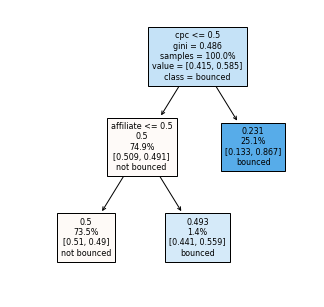

In [79]:
plt.figure(figsize=(5,5))
plot_tree(dt_clf, proportion=True, label='root', 
          feature_names=['cpc', 'affiliate'], class_names=['not bounced','bounced'], filled=True, fontsize=8)
plt.show()

In [80]:
test['predicted_bounce_DT'] = dt_clf.predict(test[features])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [81]:
dt_clf_user = DecisionTreeClassifier()

In [82]:
features_controls

['cpc', 'affiliate', 'browser_Chrome', 'device_isMobile']

In [83]:
dt_clf_user.fit(train[features_controls], train[target])

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

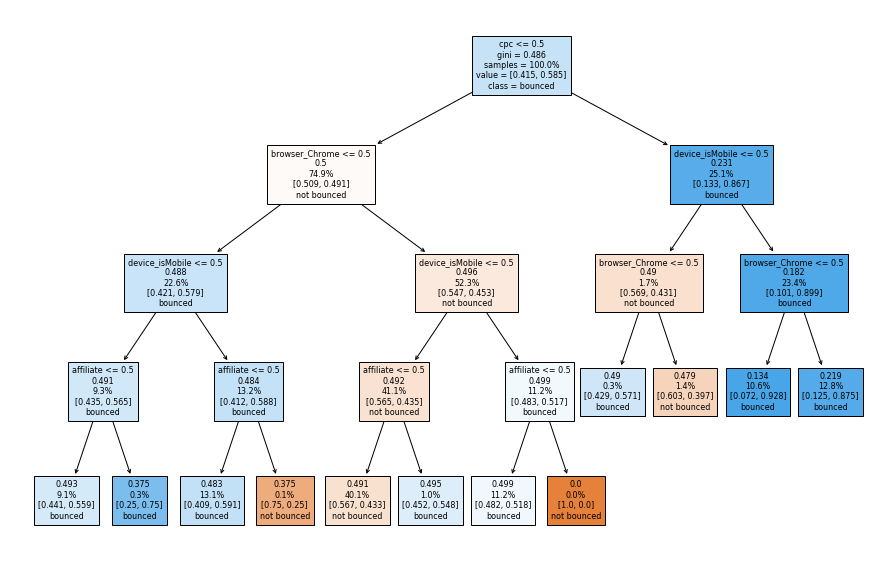

In [84]:
plt.figure(figsize=(15,10))
plot_tree(dt_clf_user, proportion=True, 
          label='root', 
          feature_names=['cpc', 'affiliate', 'browser_Chrome', 'device_isMobile'], 
          class_names=['not bounced','bounced'], 
          filled=True, fontsize=8)
plt.show()

In [85]:
test['predicted_bounce_DT_user'] = dt_clf_user.predict(test[features_controls])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [86]:
print(classification_report(test['isExit'], test['predicted_bounce_DT']))

              precision    recall  f1-score   support

           0       0.51      0.89      0.64       429
           1       0.84      0.40      0.54       618

    accuracy                           0.60      1047
   macro avg       0.67      0.64      0.59      1047
weighted avg       0.70      0.60      0.58      1047



In [87]:
print(classification_report(test['isExit'], test['predicted_bounce_DT_user']))

              precision    recall  f1-score   support

           0       0.54      0.52      0.53       429
           1       0.68      0.69      0.68       618

    accuracy                           0.62      1047
   macro avg       0.61      0.61      0.61      1047
weighted avg       0.62      0.62      0.62      1047



## Some conclusions

On the basis of the weighted average of F1-Score, it seems that the simpler model (just campaigns, without users) with a logistic regression algorithm is sufficient, but we have some improvement when adding user data (browser, device type). Changing the algorithm to Decision Trees did not seem to make much of a difference. 

How can we improve this model?
* Adding more features (IV's)?
* Testing other algorithms (for example, using K-Nearest Neighbors)?
* Fine-tuning the algorithms (i.e., changing some of their options as indicated in their documentation - https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html?)